In [1]:
# imports
import os
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms.functional as VF
from torchvision import models, transforms
from torchvision.utils import save_image
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

from fastai.vision.gan import basic_generator, gan_critic
from fastai.torch_core import requires_grad, children
from fastai.callbacks import hook_outputs

from models import Generator, FeatureLoss
from utils import paintx

In [2]:
# batch size
batch_size = 1
root = 'painting_data'

# transform
transform = transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        ])

# create dataset from images in ImageFolder
data = torchvision.datasets.ImageFolder(root=root, transform=transform)

#create sampler
sampler = RandomSampler(data, replacement=True, num_samples=100)

# create dataloader for data
dataloader = torch.utils.data.DataLoader(data, batch_size = batch_size, sampler=sampler)

In [3]:
# print out info on data and dataloader
print(data)
print(len(dataloader))

Dataset ImageFolder
    Number of datapoints: 8683
    Root Location: painting_data
    Transforms (if any): Compose(
                             Resize(size=64, interpolation=PIL.Image.BILINEAR)
                             CenterCrop(size=(64, 64))
                             ToTensor()
                         )
    Target Transforms (if any): None
10


torch.Size([1, 3, 64, 64])


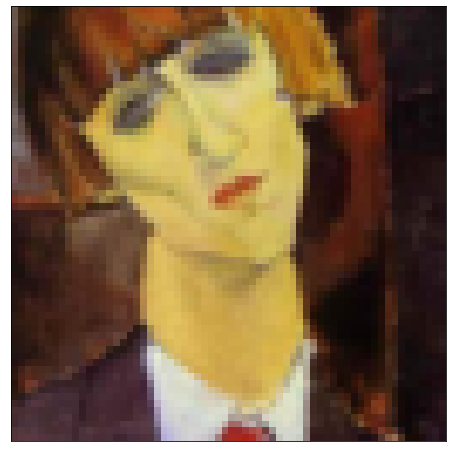

In [4]:
# visualizing data

def imshow(imgs):
    imgs = torchvision.utils.make_grid(imgs)
    npimgs = imgs.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimgs, (1,2,0)), cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    plt.show
    
dataIter = iter(dataloader)

imgs, labels = dataIter.next()

imshow(imgs)

print(imgs.shape)


In [5]:
!ls adversarial_models

brushstroke_gan_final_adversarial_critic_param.pth
brushstroke_gan_final_adversarial_generator_info.pth
brushstroke_gan_final_adversarial_generator_param.pth


In [6]:
condition_dim = 12
image_size = 64
fc_dim = int(image_size * image_size)
channels = 3
n_extra_layers = 1

# instaniate generator
generator = Generator(condition_dim=condition_dim,
                     fc_dim=fc_dim,
                     in_size=image_size,
                     n_channels=channels,
                     n_extra_layers=n_extra_layers)

# load saved generator parameters
root = "adversarial_models/"
generator.load_state_dict(torch.load(root + "brushstroke_gan_final_adversarial_generator_param.pth"))

# put generator in evaluation mode since we will only be training actions, not the generator
generator.eval()

# visualize generator layers
generator

Generator(
  (fc): Linear(in_features=12, out_features=4096, bias=True)
  (generator): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(4096, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(64, eps=1e-05, m

In [7]:
# define learning rate 
learning_rate = .01

In [8]:
# parameters for brushstrokes
num_strokes = 64

In [9]:
# the actions (e.g., parameters for brushstrokes) to optimize using RMSprop

actions = torch.empty((num_strokes, condition_dim)).uniform_(0, 1).requires_grad_()
print(f'actions.shape: {actions.shape}')

optimizer = optim.RMSprop([actions], lr=learning_rate)

actions.shape: torch.Size([64, 12])


In [10]:
Discriminator_conv = gan_critic(nf=64)

In [11]:
# Use Feature loss as test loss function

# feature loss
# using VGG16 model as feature extractor
vgg_m = models.vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o, nn.MaxPool2d)]

In [12]:
# define loss functions
adversarial_loss = torch.nn.BCELoss()
base_loss = F.mse_loss
test_loss = FeatureLoss(vgg_m, blocks[2:5], [5, 15, 2])

# define lr
lr = 0.002

# define new optimizers
dis_opt = optim.Adam(Discriminator_conv.parameters(), lr=lr, betas=(0.5, 0.999))

Training on Device : cuda!
Image: 1/10
epoch 0/1000; BSGAN MSE loss: 0.10450759530067444; DCGAN Adversarial loss:1.832068681716919
DCGAN Output | Original Image | Brushstroke GAN Output


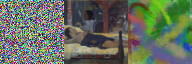

------
Brushstroke feature_loss 4.617698669433594
DCGAN feature_loss 5.740807056427002
epoch 100/1000; BSGAN MSE loss: 0.008542284369468689; DCGAN Adversarial loss:4.693935871124268
DCGAN Output | Original Image | Brushstroke GAN Output


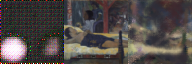

------
Brushstroke feature_loss 3.3867814540863037
DCGAN feature_loss 5.4631853103637695
epoch 200/1000; BSGAN MSE loss: 0.006454532966017723; DCGAN Adversarial loss:3.4831206798553467
DCGAN Output | Original Image | Brushstroke GAN Output


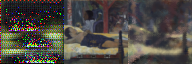

------
Brushstroke feature_loss 3.2592711448669434
DCGAN feature_loss 5.0623779296875
epoch 300/1000; BSGAN MSE loss: 0.005628753919154406; DCGAN Adversarial loss:3.116013526916504
DCGAN Output | Original Image | Brushstroke GAN Output


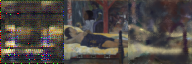

------
Brushstroke feature_loss 3.0797064304351807
DCGAN feature_loss 4.847707748413086
epoch 400/1000; BSGAN MSE loss: 0.005136603955179453; DCGAN Adversarial loss:3.1599044799804688
DCGAN Output | Original Image | Brushstroke GAN Output


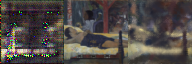

------
Brushstroke feature_loss 3.0669682025909424
DCGAN feature_loss 4.861974716186523
epoch 500/1000; BSGAN MSE loss: 0.004830813035368919; DCGAN Adversarial loss:3.393157482147217
DCGAN Output | Original Image | Brushstroke GAN Output


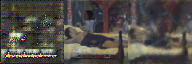

------
Brushstroke feature_loss 2.9779882431030273
DCGAN feature_loss 4.733307361602783
epoch 600/1000; BSGAN MSE loss: 0.004613990429788828; DCGAN Adversarial loss:3.460294008255005
DCGAN Output | Original Image | Brushstroke GAN Output


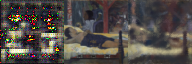

------
Brushstroke feature_loss 2.939473867416382
DCGAN feature_loss 4.483475685119629
epoch 700/1000; BSGAN MSE loss: 0.004453830420970917; DCGAN Adversarial loss:3.467694044113159
DCGAN Output | Original Image | Brushstroke GAN Output


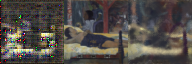

------
Brushstroke feature_loss 2.889951705932617
DCGAN feature_loss 4.803826808929443
epoch 800/1000; BSGAN MSE loss: 0.004332644399255514; DCGAN Adversarial loss:3.4481875896453857
DCGAN Output | Original Image | Brushstroke GAN Output


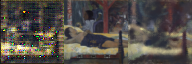

------
Brushstroke feature_loss 2.879603385925293
DCGAN feature_loss 4.503745079040527
epoch 900/1000; BSGAN MSE loss: 0.0042314790189266205; DCGAN Adversarial loss:3.398989200592041
DCGAN Output | Original Image | Brushstroke GAN Output


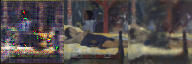

------
Brushstroke feature_loss 2.8975815773010254
DCGAN feature_loss 3.95871901512146
--- final ---
epoch 999/1000; BSGAN feature loss: 0.004138848278671503; DCGAN feature loss:3.3805997371673584
DCGAN Output | Original Image | Brushstroke GAN Output


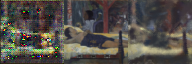

--------------------
Image: 2/10
epoch 0/1000; BSGAN MSE loss: 0.06910093128681183; DCGAN Adversarial loss:8.95261001586914
DCGAN Output | Original Image | Brushstroke GAN Output


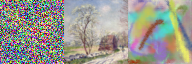

------
Brushstroke feature_loss 5.188552379608154
DCGAN feature_loss 5.905409812927246
epoch 100/1000; BSGAN MSE loss: 0.006461364682763815; DCGAN Adversarial loss:2.404750347137451
DCGAN Output | Original Image | Brushstroke GAN Output


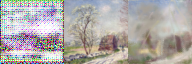

------
Brushstroke feature_loss 3.574601411819458
DCGAN feature_loss 6.364311695098877
epoch 200/1000; BSGAN MSE loss: 0.005223597399890423; DCGAN Adversarial loss:7.631744861602783
DCGAN Output | Original Image | Brushstroke GAN Output


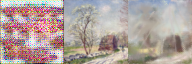

------
Brushstroke feature_loss 3.492746114730835
DCGAN feature_loss 5.333654403686523
epoch 300/1000; BSGAN MSE loss: 0.004695506766438484; DCGAN Adversarial loss:14.475859642028809
DCGAN Output | Original Image | Brushstroke GAN Output


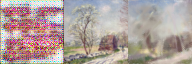

------
Brushstroke feature_loss 3.3256983757019043
DCGAN feature_loss 5.573626518249512
epoch 400/1000; BSGAN MSE loss: 0.0044060503132641315; DCGAN Adversarial loss:17.756446838378906
DCGAN Output | Original Image | Brushstroke GAN Output


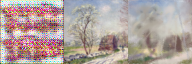

------
Brushstroke feature_loss 3.277156352996826
DCGAN feature_loss 5.429457664489746
epoch 500/1000; BSGAN MSE loss: 0.004195815417915583; DCGAN Adversarial loss:19.84041404724121
DCGAN Output | Original Image | Brushstroke GAN Output


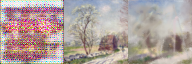

------
Brushstroke feature_loss 3.230804443359375
DCGAN feature_loss 5.480349540710449
epoch 600/1000; BSGAN MSE loss: 0.004044866189360619; DCGAN Adversarial loss:21.235267639160156
DCGAN Output | Original Image | Brushstroke GAN Output


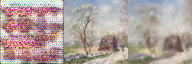

------
Brushstroke feature_loss 3.253934621810913
DCGAN feature_loss 5.556026935577393
epoch 700/1000; BSGAN MSE loss: 0.003927358891814947; DCGAN Adversarial loss:22.14763832092285
DCGAN Output | Original Image | Brushstroke GAN Output


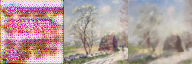

------
Brushstroke feature_loss 3.195298910140991
DCGAN feature_loss 5.701527118682861
epoch 800/1000; BSGAN MSE loss: 0.0038325858768075705; DCGAN Adversarial loss:22.83221435546875
DCGAN Output | Original Image | Brushstroke GAN Output


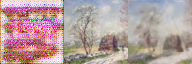

------
Brushstroke feature_loss 3.069262742996216
DCGAN feature_loss 5.514035701751709
epoch 900/1000; BSGAN MSE loss: 0.0037589322309941053; DCGAN Adversarial loss:23.364824295043945
DCGAN Output | Original Image | Brushstroke GAN Output


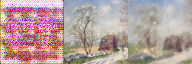

------
Brushstroke feature_loss 3.129136323928833
DCGAN feature_loss 5.5444865226745605
--- final ---
epoch 999/1000; BSGAN feature loss: 0.0036960123106837273; DCGAN feature loss:23.787179946899414
DCGAN Output | Original Image | Brushstroke GAN Output


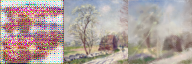

--------------------
Image: 3/10
epoch 0/1000; BSGAN MSE loss: 0.1053607165813446; DCGAN Adversarial loss:27.63102149963379
DCGAN Output | Original Image | Brushstroke GAN Output


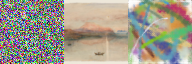

------
Brushstroke feature_loss 5.009331703186035
DCGAN feature_loss 5.913076400756836
epoch 100/1000; BSGAN MSE loss: 0.0043838671408593655; DCGAN Adversarial loss:29.26485824584961
DCGAN Output | Original Image | Brushstroke GAN Output


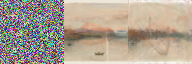

------
Brushstroke feature_loss 2.7059385776519775
DCGAN feature_loss 6.0355963706970215
epoch 200/1000; BSGAN MSE loss: 0.0029109553433954716; DCGAN Adversarial loss:29.325727462768555
DCGAN Output | Original Image | Brushstroke GAN Output


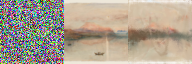

------
Brushstroke feature_loss 2.4263930320739746
DCGAN feature_loss 5.805922508239746
epoch 300/1000; BSGAN MSE loss: 0.0023609809577465057; DCGAN Adversarial loss:29.24994468688965
DCGAN Output | Original Image | Brushstroke GAN Output


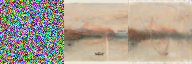

------
Brushstroke feature_loss 2.4361095428466797
DCGAN feature_loss 5.840710163116455
epoch 400/1000; BSGAN MSE loss: 0.0020629127975553274; DCGAN Adversarial loss:29.060081481933594
DCGAN Output | Original Image | Brushstroke GAN Output


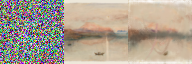

------
Brushstroke feature_loss 2.392470359802246
DCGAN feature_loss 5.894725799560547
epoch 500/1000; BSGAN MSE loss: 0.0018775886856019497; DCGAN Adversarial loss:29.00060272216797
DCGAN Output | Original Image | Brushstroke GAN Output


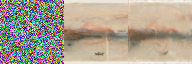

------
Brushstroke feature_loss 2.254391670227051
DCGAN feature_loss 5.9693922996521
epoch 600/1000; BSGAN MSE loss: 0.0017396496841683984; DCGAN Adversarial loss:28.772716522216797
DCGAN Output | Original Image | Brushstroke GAN Output


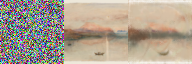

------
Brushstroke feature_loss 2.1974079608917236
DCGAN feature_loss 5.790678024291992
epoch 700/1000; BSGAN MSE loss: 0.001638900488615036; DCGAN Adversarial loss:28.847728729248047
DCGAN Output | Original Image | Brushstroke GAN Output


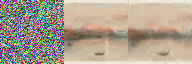

------
Brushstroke feature_loss 2.155592918395996
DCGAN feature_loss 5.979479789733887
epoch 800/1000; BSGAN MSE loss: 0.0015576087171211839; DCGAN Adversarial loss:28.695837020874023
DCGAN Output | Original Image | Brushstroke GAN Output


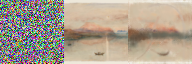

------
Brushstroke feature_loss 2.0686659812927246
DCGAN feature_loss 5.897163391113281
epoch 900/1000; BSGAN MSE loss: 0.0014918578090146184; DCGAN Adversarial loss:28.645263671875
DCGAN Output | Original Image | Brushstroke GAN Output


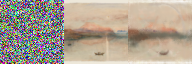

------
Brushstroke feature_loss 2.079800844192505
DCGAN feature_loss 5.912267208099365
--- final ---
epoch 999/1000; BSGAN feature loss: 0.0014344534138217568; DCGAN feature loss:28.71050262451172
DCGAN Output | Original Image | Brushstroke GAN Output


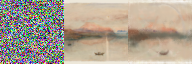

--------------------
Image: 4/10
epoch 0/1000; BSGAN MSE loss: 0.09380516409873962; DCGAN Adversarial loss:27.63102149963379
DCGAN Output | Original Image | Brushstroke GAN Output


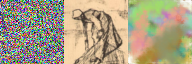

------
Brushstroke feature_loss 5.071117877960205
DCGAN feature_loss 5.715590953826904
epoch 100/1000; BSGAN MSE loss: 0.013707968406379223; DCGAN Adversarial loss:28.11189079284668
DCGAN Output | Original Image | Brushstroke GAN Output


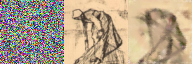

------
Brushstroke feature_loss 3.6121678352355957
DCGAN feature_loss 5.841691493988037
epoch 200/1000; BSGAN MSE loss: 0.011083654128015041; DCGAN Adversarial loss:28.46462059020996
DCGAN Output | Original Image | Brushstroke GAN Output


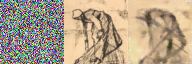

------
Brushstroke feature_loss 3.0557315349578857
DCGAN feature_loss 5.838723182678223
epoch 300/1000; BSGAN MSE loss: 0.00984982866793871; DCGAN Adversarial loss:28.766550064086914
DCGAN Output | Original Image | Brushstroke GAN Output


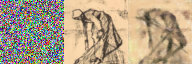

------
Brushstroke feature_loss 3.0940747261047363
DCGAN feature_loss 5.838891506195068
epoch 400/1000; BSGAN MSE loss: 0.009117808192968369; DCGAN Adversarial loss:28.772735595703125
DCGAN Output | Original Image | Brushstroke GAN Output


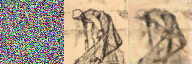

------
Brushstroke feature_loss 3.0224416255950928
DCGAN feature_loss 6.1155548095703125
epoch 500/1000; BSGAN MSE loss: 0.008603878319263458; DCGAN Adversarial loss:28.658315658569336
DCGAN Output | Original Image | Brushstroke GAN Output


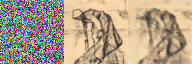

------
Brushstroke feature_loss 3.013514757156372
DCGAN feature_loss 5.938499450683594
epoch 600/1000; BSGAN MSE loss: 0.008206760510802269; DCGAN Adversarial loss:28.78437614440918
DCGAN Output | Original Image | Brushstroke GAN Output


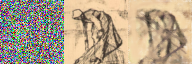

------
Brushstroke feature_loss 2.845085859298706
DCGAN feature_loss 5.738126277923584
epoch 700/1000; BSGAN MSE loss: 0.007898551411926746; DCGAN Adversarial loss:28.769723892211914
DCGAN Output | Original Image | Brushstroke GAN Output


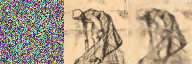

------
Brushstroke feature_loss 2.8244664669036865
DCGAN feature_loss 5.8530778884887695
epoch 800/1000; BSGAN MSE loss: 0.007654048502445221; DCGAN Adversarial loss:28.840761184692383
DCGAN Output | Original Image | Brushstroke GAN Output


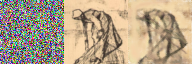

------
Brushstroke feature_loss 2.7207984924316406
DCGAN feature_loss 5.6911845207214355
epoch 900/1000; BSGAN MSE loss: 0.007461319677531719; DCGAN Adversarial loss:28.768465042114258
DCGAN Output | Original Image | Brushstroke GAN Output


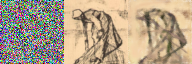

------
Brushstroke feature_loss 2.750948905944824
DCGAN feature_loss 5.740967273712158
--- final ---
epoch 999/1000; BSGAN feature loss: 0.00729448813945055; DCGAN feature loss:28.807222366333008
DCGAN Output | Original Image | Brushstroke GAN Output


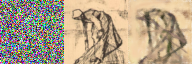

--------------------
Image: 5/10
epoch 0/1000; BSGAN MSE loss: 0.05792119726538658; DCGAN Adversarial loss:27.63102149963379
DCGAN Output | Original Image | Brushstroke GAN Output


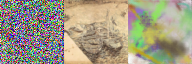

------
Brushstroke feature_loss 4.854358673095703
DCGAN feature_loss 6.175193786621094
epoch 100/1000; BSGAN MSE loss: 0.0061614783480763435; DCGAN Adversarial loss:28.099645614624023
DCGAN Output | Original Image | Brushstroke GAN Output


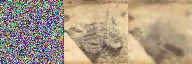

------
Brushstroke feature_loss 3.270059585571289
DCGAN feature_loss 6.10144567489624
epoch 200/1000; BSGAN MSE loss: 0.005023084580898285; DCGAN Adversarial loss:28.380023956298828
DCGAN Output | Original Image | Brushstroke GAN Output


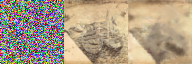

------
Brushstroke feature_loss 3.0806329250335693
DCGAN feature_loss 6.148985862731934
epoch 300/1000; BSGAN MSE loss: 0.004481865558773279; DCGAN Adversarial loss:28.328001022338867
DCGAN Output | Original Image | Brushstroke GAN Output


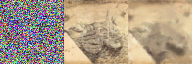

------
Brushstroke feature_loss 3.014180898666382
DCGAN feature_loss 6.195873737335205
epoch 400/1000; BSGAN MSE loss: 0.004164611920714378; DCGAN Adversarial loss:28.549945831298828
DCGAN Output | Original Image | Brushstroke GAN Output


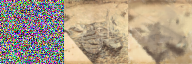

------
Brushstroke feature_loss 2.8901243209838867
DCGAN feature_loss 6.187704086303711
epoch 500/1000; BSGAN MSE loss: 0.003942803479731083; DCGAN Adversarial loss:28.597883224487305
DCGAN Output | Original Image | Brushstroke GAN Output


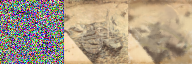

------
Brushstroke feature_loss 2.944099187850952
DCGAN feature_loss 6.015299320220947
epoch 600/1000; BSGAN MSE loss: 0.0037806162144988775; DCGAN Adversarial loss:28.4370059967041
DCGAN Output | Original Image | Brushstroke GAN Output


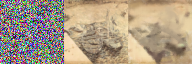

------
Brushstroke feature_loss 2.8735945224761963
DCGAN feature_loss 6.04690408706665
epoch 700/1000; BSGAN MSE loss: 0.0036512836813926697; DCGAN Adversarial loss:28.322031021118164
DCGAN Output | Original Image | Brushstroke GAN Output


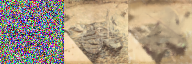

------
Brushstroke feature_loss 2.9255497455596924
DCGAN feature_loss 5.999561309814453
epoch 800/1000; BSGAN MSE loss: 0.003545770887285471; DCGAN Adversarial loss:28.38304328918457
DCGAN Output | Original Image | Brushstroke GAN Output


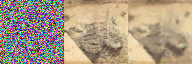

------
Brushstroke feature_loss 2.8600080013275146
DCGAN feature_loss 6.088910102844238
epoch 900/1000; BSGAN MSE loss: 0.0034623031970113516; DCGAN Adversarial loss:28.537385940551758
DCGAN Output | Original Image | Brushstroke GAN Output


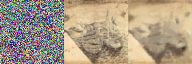

------
Brushstroke feature_loss 2.7988548278808594
DCGAN feature_loss 6.015146255493164
--- final ---
epoch 999/1000; BSGAN feature loss: 0.0033880581613630056; DCGAN feature loss:28.485492706298828
DCGAN Output | Original Image | Brushstroke GAN Output


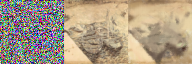

--------------------
Image: 6/10
epoch 0/1000; BSGAN MSE loss: 0.13464872539043427; DCGAN Adversarial loss:27.63102149963379
DCGAN Output | Original Image | Brushstroke GAN Output


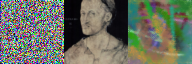

------
Brushstroke feature_loss 5.108372688293457
DCGAN feature_loss 5.928088665008545
epoch 100/1000; BSGAN MSE loss: 0.008085009641945362; DCGAN Adversarial loss:28.78761863708496
DCGAN Output | Original Image | Brushstroke GAN Output


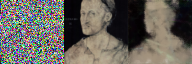

------
Brushstroke feature_loss 3.3928887844085693
DCGAN feature_loss 6.00648832321167
epoch 200/1000; BSGAN MSE loss: 0.005600989330559969; DCGAN Adversarial loss:28.439144134521484
DCGAN Output | Original Image | Brushstroke GAN Output


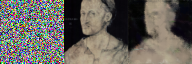

------
Brushstroke feature_loss 3.2210588455200195
DCGAN feature_loss 5.980748653411865
epoch 300/1000; BSGAN MSE loss: 0.004614546429365873; DCGAN Adversarial loss:28.35052490234375
DCGAN Output | Original Image | Brushstroke GAN Output


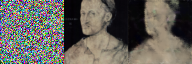

------
Brushstroke feature_loss 3.1014363765716553
DCGAN feature_loss 5.934986114501953
epoch 400/1000; BSGAN MSE loss: 0.004085645545274019; DCGAN Adversarial loss:28.428260803222656
DCGAN Output | Original Image | Brushstroke GAN Output


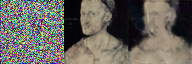

------
Brushstroke feature_loss 3.286428689956665
DCGAN feature_loss 6.04857873916626
epoch 500/1000; BSGAN MSE loss: 0.003749547991901636; DCGAN Adversarial loss:28.717966079711914
DCGAN Output | Original Image | Brushstroke GAN Output


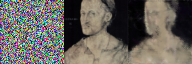

------
Brushstroke feature_loss 3.067153215408325
DCGAN feature_loss 6.109355926513672
epoch 600/1000; BSGAN MSE loss: 0.0034843836911022663; DCGAN Adversarial loss:28.813156127929688
DCGAN Output | Original Image | Brushstroke GAN Output


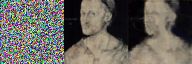

------
Brushstroke feature_loss 2.89750337600708
DCGAN feature_loss 6.061175346374512
epoch 700/1000; BSGAN MSE loss: 0.0032989727333188057; DCGAN Adversarial loss:28.958202362060547
DCGAN Output | Original Image | Brushstroke GAN Output


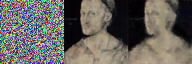

------
Brushstroke feature_loss 2.872978448867798
DCGAN feature_loss 5.934174060821533
epoch 800/1000; BSGAN MSE loss: 0.0031520137563347816; DCGAN Adversarial loss:28.792522430419922
DCGAN Output | Original Image | Brushstroke GAN Output


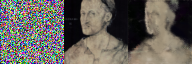

------
Brushstroke feature_loss 2.9608566761016846
DCGAN feature_loss 6.0285468101501465
epoch 900/1000; BSGAN MSE loss: 0.003048105863854289; DCGAN Adversarial loss:28.79099464416504
DCGAN Output | Original Image | Brushstroke GAN Output


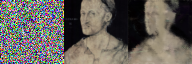

------
Brushstroke feature_loss 3.057847738265991
DCGAN feature_loss 5.859880447387695
--- final ---
epoch 999/1000; BSGAN feature loss: 0.002945638494566083; DCGAN feature loss:28.957481384277344
DCGAN Output | Original Image | Brushstroke GAN Output


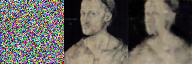

--------------------
Image: 7/10
epoch 0/1000; BSGAN MSE loss: 0.07629157602787018; DCGAN Adversarial loss:27.63102149963379
DCGAN Output | Original Image | Brushstroke GAN Output


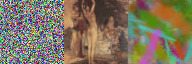

------
Brushstroke feature_loss 4.763880252838135
DCGAN feature_loss 5.425016403198242
epoch 100/1000; BSGAN MSE loss: 0.007119452115148306; DCGAN Adversarial loss:29.1630859375
DCGAN Output | Original Image | Brushstroke GAN Output


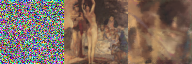

------
Brushstroke feature_loss 2.797083616256714
DCGAN feature_loss 5.294516086578369
epoch 200/1000; BSGAN MSE loss: 0.005380466114729643; DCGAN Adversarial loss:28.97923469543457
DCGAN Output | Original Image | Brushstroke GAN Output


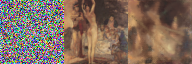

------
Brushstroke feature_loss 2.772578001022339
DCGAN feature_loss 5.209846496582031
epoch 300/1000; BSGAN MSE loss: 0.004666395019739866; DCGAN Adversarial loss:28.904277801513672
DCGAN Output | Original Image | Brushstroke GAN Output


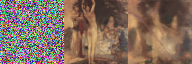

------
Brushstroke feature_loss 2.618034839630127
DCGAN feature_loss 5.178181171417236
epoch 400/1000; BSGAN MSE loss: 0.004271138459444046; DCGAN Adversarial loss:28.681188583374023
DCGAN Output | Original Image | Brushstroke GAN Output


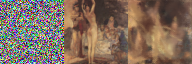

------
Brushstroke feature_loss 2.592769145965576
DCGAN feature_loss 5.300045967102051
epoch 500/1000; BSGAN MSE loss: 0.004023450426757336; DCGAN Adversarial loss:28.59132194519043
DCGAN Output | Original Image | Brushstroke GAN Output


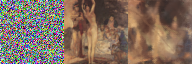

------
Brushstroke feature_loss 2.555774450302124
DCGAN feature_loss 5.164906024932861
epoch 600/1000; BSGAN MSE loss: 0.003818066092208028; DCGAN Adversarial loss:28.692237854003906
DCGAN Output | Original Image | Brushstroke GAN Output


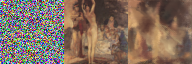

------
Brushstroke feature_loss 2.510026216506958
DCGAN feature_loss 5.149823188781738
epoch 700/1000; BSGAN MSE loss: 0.003658690256997943; DCGAN Adversarial loss:28.868967056274414
DCGAN Output | Original Image | Brushstroke GAN Output


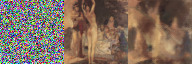

------
Brushstroke feature_loss 2.515286684036255
DCGAN feature_loss 5.338360786437988
epoch 800/1000; BSGAN MSE loss: 0.0035419147461652756; DCGAN Adversarial loss:29.00090789794922
DCGAN Output | Original Image | Brushstroke GAN Output


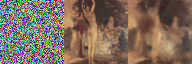

------
Brushstroke feature_loss 2.590768337249756
DCGAN feature_loss 5.289310932159424
epoch 900/1000; BSGAN MSE loss: 0.0034469952806830406; DCGAN Adversarial loss:29.032793045043945
DCGAN Output | Original Image | Brushstroke GAN Output


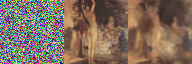

------
Brushstroke feature_loss 2.5322470664978027
DCGAN feature_loss 5.410167217254639
--- final ---
epoch 999/1000; BSGAN feature loss: 0.0033631576225161552; DCGAN feature loss:29.20665168762207
DCGAN Output | Original Image | Brushstroke GAN Output


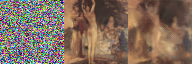

--------------------
Image: 8/10
epoch 0/1000; BSGAN MSE loss: 0.09405867010354996; DCGAN Adversarial loss:27.63102149963379
DCGAN Output | Original Image | Brushstroke GAN Output


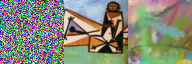

------
Brushstroke feature_loss 4.984664440155029
DCGAN feature_loss 6.166555404663086
epoch 100/1000; BSGAN MSE loss: 0.026540152728557587; DCGAN Adversarial loss:29.755878448486328
DCGAN Output | Original Image | Brushstroke GAN Output


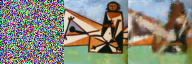

------
Brushstroke feature_loss 4.077968120574951
DCGAN feature_loss 6.309316158294678
epoch 200/1000; BSGAN MSE loss: 0.022634053602814674; DCGAN Adversarial loss:29.55531120300293
DCGAN Output | Original Image | Brushstroke GAN Output


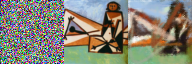

------
Brushstroke feature_loss 4.078332424163818
DCGAN feature_loss 6.435314178466797
epoch 300/1000; BSGAN MSE loss: 0.02049892768263817; DCGAN Adversarial loss:29.27177619934082
DCGAN Output | Original Image | Brushstroke GAN Output


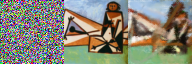

------
Brushstroke feature_loss 3.9053101539611816
DCGAN feature_loss 6.215350151062012
epoch 400/1000; BSGAN MSE loss: 0.019085215404629707; DCGAN Adversarial loss:29.148775100708008
DCGAN Output | Original Image | Brushstroke GAN Output


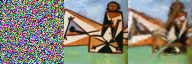

------
Brushstroke feature_loss 3.718580484390259
DCGAN feature_loss 6.267475605010986
epoch 500/1000; BSGAN MSE loss: 0.018155232071876526; DCGAN Adversarial loss:29.47968864440918
DCGAN Output | Original Image | Brushstroke GAN Output


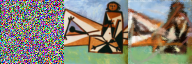

------
Brushstroke feature_loss 3.6073057651519775
DCGAN feature_loss 6.675613880157471
epoch 600/1000; BSGAN MSE loss: 0.017459269613027573; DCGAN Adversarial loss:29.722444534301758
DCGAN Output | Original Image | Brushstroke GAN Output


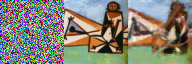

------
Brushstroke feature_loss 3.8674657344818115
DCGAN feature_loss 6.24141263961792
epoch 700/1000; BSGAN MSE loss: 0.01692156121134758; DCGAN Adversarial loss:29.66008949279785
DCGAN Output | Original Image | Brushstroke GAN Output


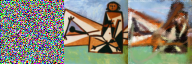

------
Brushstroke feature_loss 3.634753942489624
DCGAN feature_loss 6.146486282348633
epoch 800/1000; BSGAN MSE loss: 0.016483163461089134; DCGAN Adversarial loss:29.738462448120117
DCGAN Output | Original Image | Brushstroke GAN Output


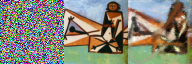

------
Brushstroke feature_loss 3.698262929916382
DCGAN feature_loss 6.24416971206665
epoch 900/1000; BSGAN MSE loss: 0.01611514389514923; DCGAN Adversarial loss:29.76466941833496
DCGAN Output | Original Image | Brushstroke GAN Output


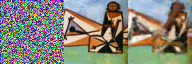

------
Brushstroke feature_loss 3.617361307144165
DCGAN feature_loss 6.400417327880859
--- final ---
epoch 999/1000; BSGAN feature loss: 0.015822794288396835; DCGAN feature loss:29.805477142333984
DCGAN Output | Original Image | Brushstroke GAN Output


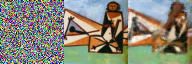

--------------------
Image: 9/10
epoch 0/1000; BSGAN MSE loss: 0.04424753785133362; DCGAN Adversarial loss:27.63102149963379
DCGAN Output | Original Image | Brushstroke GAN Output


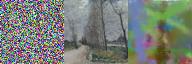

------
Brushstroke feature_loss 4.399752140045166
DCGAN feature_loss 5.425483703613281
epoch 100/1000; BSGAN MSE loss: 0.005265445448458195; DCGAN Adversarial loss:28.692825317382812
DCGAN Output | Original Image | Brushstroke GAN Output


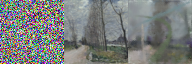

------
Brushstroke feature_loss 3.1234817504882812
DCGAN feature_loss 5.296050548553467
epoch 200/1000; BSGAN MSE loss: 0.0042462958954274654; DCGAN Adversarial loss:28.422452926635742
DCGAN Output | Original Image | Brushstroke GAN Output


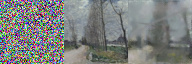

------
Brushstroke feature_loss 3.067615032196045
DCGAN feature_loss 5.306640625
epoch 300/1000; BSGAN MSE loss: 0.0037942063063383102; DCGAN Adversarial loss:28.345111846923828
DCGAN Output | Original Image | Brushstroke GAN Output


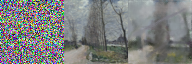

------
Brushstroke feature_loss 2.9393739700317383
DCGAN feature_loss 5.400864601135254
epoch 400/1000; BSGAN MSE loss: 0.0035282860044389963; DCGAN Adversarial loss:28.57283592224121
DCGAN Output | Original Image | Brushstroke GAN Output


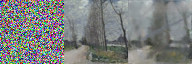

------
Brushstroke feature_loss 2.8492391109466553
DCGAN feature_loss 5.308084964752197
epoch 500/1000; BSGAN MSE loss: 0.0033635273575782776; DCGAN Adversarial loss:29.165781021118164
DCGAN Output | Original Image | Brushstroke GAN Output


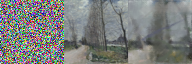

------
Brushstroke feature_loss 2.8162078857421875
DCGAN feature_loss 5.255073070526123
epoch 600/1000; BSGAN MSE loss: 0.0032422852236777544; DCGAN Adversarial loss:28.91041374206543
DCGAN Output | Original Image | Brushstroke GAN Output


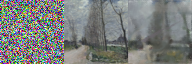

------
Brushstroke feature_loss 2.781371831893921
DCGAN feature_loss 5.328897953033447
epoch 700/1000; BSGAN MSE loss: 0.0031405508052557707; DCGAN Adversarial loss:28.879220962524414
DCGAN Output | Original Image | Brushstroke GAN Output


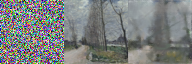

------
Brushstroke feature_loss 2.8573288917541504
DCGAN feature_loss 5.4587721824646
epoch 800/1000; BSGAN MSE loss: 0.0030658114701509476; DCGAN Adversarial loss:28.781404495239258
DCGAN Output | Original Image | Brushstroke GAN Output


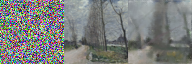

------
Brushstroke feature_loss 2.804028034210205
DCGAN feature_loss 5.577084541320801
epoch 900/1000; BSGAN MSE loss: 0.0030043069273233414; DCGAN Adversarial loss:28.900074005126953
DCGAN Output | Original Image | Brushstroke GAN Output


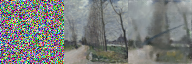

------
Brushstroke feature_loss 2.793423652648926
DCGAN feature_loss 5.443582057952881
--- final ---
epoch 999/1000; BSGAN feature loss: 0.002949400106444955; DCGAN feature loss:28.830968856811523
DCGAN Output | Original Image | Brushstroke GAN Output


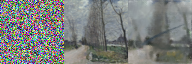

--------------------
Image: 10/10
epoch 0/1000; BSGAN MSE loss: 0.06875783950090408; DCGAN Adversarial loss:27.63102149963379
DCGAN Output | Original Image | Brushstroke GAN Output


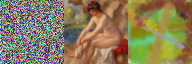

------
Brushstroke feature_loss 4.2813496589660645
DCGAN feature_loss 5.87382173538208
epoch 100/1000; BSGAN MSE loss: 0.008913706056773663; DCGAN Adversarial loss:28.764442443847656
DCGAN Output | Original Image | Brushstroke GAN Output


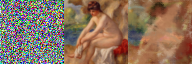

------
Brushstroke feature_loss 3.2908096313476562
DCGAN feature_loss 5.89301872253418
epoch 200/1000; BSGAN MSE loss: 0.007060909643769264; DCGAN Adversarial loss:28.200542449951172
DCGAN Output | Original Image | Brushstroke GAN Output


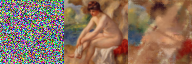

------
Brushstroke feature_loss 3.164767265319824
DCGAN feature_loss 5.841940879821777
epoch 300/1000; BSGAN MSE loss: 0.0062255035154521465; DCGAN Adversarial loss:28.590927124023438
DCGAN Output | Original Image | Brushstroke GAN Output


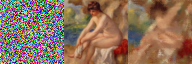

------
Brushstroke feature_loss 3.1217100620269775
DCGAN feature_loss 5.858508110046387
epoch 400/1000; BSGAN MSE loss: 0.005711350589990616; DCGAN Adversarial loss:28.63782501220703
DCGAN Output | Original Image | Brushstroke GAN Output


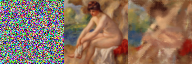

------
Brushstroke feature_loss 2.8786606788635254
DCGAN feature_loss 5.7604217529296875
epoch 500/1000; BSGAN MSE loss: 0.005353519693017006; DCGAN Adversarial loss:28.556907653808594
DCGAN Output | Original Image | Brushstroke GAN Output


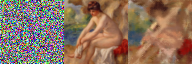

------
Brushstroke feature_loss 2.8583552837371826
DCGAN feature_loss 5.757691383361816
epoch 600/1000; BSGAN MSE loss: 0.00508491974323988; DCGAN Adversarial loss:28.497617721557617
DCGAN Output | Original Image | Brushstroke GAN Output


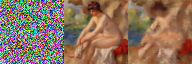

------
Brushstroke feature_loss 2.77301025390625
DCGAN feature_loss 5.703407287597656
epoch 700/1000; BSGAN MSE loss: 0.004866133444011211; DCGAN Adversarial loss:28.373994827270508
DCGAN Output | Original Image | Brushstroke GAN Output


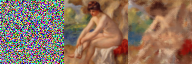

------
Brushstroke feature_loss 3.0406970977783203
DCGAN feature_loss 5.922189712524414
epoch 800/1000; BSGAN MSE loss: 0.004687626380473375; DCGAN Adversarial loss:28.43143653869629
DCGAN Output | Original Image | Brushstroke GAN Output


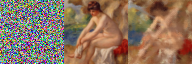

------
Brushstroke feature_loss 2.77884840965271
DCGAN feature_loss 5.731966972351074
epoch 900/1000; BSGAN MSE loss: 0.004536509979516268; DCGAN Adversarial loss:28.53542137145996
DCGAN Output | Original Image | Brushstroke GAN Output


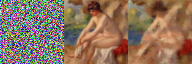

------
Brushstroke feature_loss 2.8619155883789062
DCGAN feature_loss 5.869248390197754
--- final ---
epoch 999/1000; BSGAN feature loss: 0.004416359588503838; DCGAN feature loss:28.504362106323242
DCGAN Output | Original Image | Brushstroke GAN Output


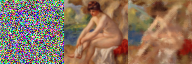

--------------------
----------
DONE TRAINING!


In [13]:
# training
train_epoch = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Training on Device : {device}!')

generator.to(device)
Discriminator_conv.to(device)
adversarial_loss.to(device)


brushstroke_epoch_losses = {}
DCGAN_epoch_losses = {}

brushstroke_epoch_feature_losses = {}
DCGAN_epoch_feature_losses = {}

for i, (base_image, label) in enumerate(dataloader):

    epoch_images = []

    # reset action and DCGAN after each image to train fresh
    # the actions to optimize using RMSprop
    actions = torch.empty((num_strokes, condition_dim)).uniform_(0, 1).requires_grad_()
    optimizer = optim.RMSprop([actions], lr=learning_rate)
    actions.to(device)

    # define DCGAN generator
    Generator_conv = basic_generator(in_size=64,
                            n_channels=3,
                            noise_sz=fc_dim
                            )
    gen_opt = optim.Adam(Generator_conv.parameters(), lr=lr, betas=(0.5,0.999))
    Generator_conv.to(device)

    print(f'Image: {i+1}/{len(dataloader)}')

    brushstroke_losses = []
    DCGAN_losses = []

    X = base_image

    base_image = base_image.squeeze(0).to(device)


    # training Brushstroke GAN action space w/feature loss


    for epoch in range(train_epoch):
        def closure():

            actions.data.clamp_(0, 1)

            optimizer.zero_grad()

            num_strokes, condition_dim = actions.shape


            strokes = generator(actions.view(num_strokes, condition_dim).to(device))

            canvas = paintx(strokes)
            
            the_loss = base_loss(canvas, base_image.view(1, *base_image.shape))

            the_loss.backward()

            brushstroke_losses.append(the_loss.item())

            return the_loss.item()

        optimizer.step(closure)


        # training DCGAN

        #train w/ real
        dis_opt.zero_grad()
        X = X.to(device)
        mb_size = X.size(0)

        one_labels = torch.ones(mb_size, 1).to(device)
        zero_labels = torch.zeros(mb_size, 1).to(device)


        # D loss
        D_real = torch.sigmoid(Discriminator_conv(X))
        D_real_loss = adversarial_loss(D_real, one_labels)
        D_real_loss.backward()

        #train w/ fake
        # noise
        z = torch.randn(mb_size, fc_dim, 1, 1).to(device)
        D_fake = torch.sigmoid(Discriminator_conv(Generator_conv(z)))
        D_fake_loss = adversarial_loss(D_fake, zero_labels)
        D_fake_loss.backward()
        D_loss = D_real_loss + D_fake_loss


        # D backprop
        dis_opt.step()

        # update G
        gen_opt.zero_grad()
        # G loss
        z = torch.randn(mb_size, fc_dim,1,1).to(device)

        # generate images
        gen_imgs = Generator_conv(z)

        G_loss = adversarial_loss(torch.sigmoid(Discriminator_conv(gen_imgs)), one_labels)

        DCGAN_losses.append(G_loss)


        # G backprop
        G_loss.backward()
        gen_opt.step()



        if epoch % 100 == 0:
            BSGAN_loss_epoch = torch.mean(torch.tensor(brushstroke_losses)).item()
            DCGAN_loss_epoch = torch.mean(torch.tensor(DCGAN_losses)).item()
            
            print(f'epoch {epoch}/{train_epoch}; BSGAN MSE loss: {BSGAN_loss_epoch}; DCGAN Adversarial loss:{DCGAN_loss_epoch}')
            
            brushstroke_epoch_losses[epoch] = BSGAN_loss_epoch
            DCGAN_epoch_losses[epoch] = DCGAN_loss_epoch
            
            # Brushstroke GAN output
            actions.data.clamp_(0, 1)
            num_strokes, condition_dim = actions.shape
            strokes = generator(actions.view(num_strokes, condition_dim).to(device))
            img = paintx(strokes).squeeze().cpu()


            # DCGAN Output
            samples = Generator_conv(z).detach()
            samples = samples.view(samples.size(0), channels, image_size, image_size).cpu()
            samples = samples.squeeze(0)

            # display outputs

            epoch_output = torch.cat((samples, 
                                      base_image.clone().cpu(), 
                                      F.interpolate(img.view(1, *img.shape) , 
                                            size=(64, 64), 
                                            mode='bilinear', 
                                            align_corners=False).
                                      squeeze()), 
                                     dim=2)
            epoch_images.append(epoch_output)

            print('DCGAN Output | Original Image | Brushstroke GAN Output')
            display(VF.to_pil_image(epoch_output))

            print('------')
            test_loss.cpu()
            loss_brush = test_loss(img.view(1, *img.shape), X.cpu())
            loss_DCGAN = test_loss(samples.view(1, *samples.shape), X.cpu())
            print(f'Brushstroke feature_loss {loss_brush}')
            print(f'DCGAN feature_loss {loss_DCGAN}')
            
            brushstroke_epoch_feature_losses[epoch] = loss_brush
            DCGAN_epoch_feature_losses[epoch] = loss_DCGAN


    # Final Outputs for this train_epoch

    actions.data.clamp_(0, 1)
    num_strokes, condition_dim = actions.shape
    strokes = generator(actions.view(num_strokes, condition_dim).to(device))
    samples = Generator_conv(z).detach()
    samples = samples.view(samples.size(0), channels, image_size, image_size).cpu()
    samples = samples.squeeze(0)

    # concatenate DCGAN output, Original Image, and BSGAN output
    final_output = torch.cat((samples, 
                              base_image.clone().cpu(), 
                              F.interpolate(img.view(1, *img.shape) , 
                                            size=(64, 64), 
                                            mode='bilinear', 
                                            align_corners=False).
                              squeeze()), 
                             dim=2)



    print('--- final ---')
    print(f'epoch {epoch}/{train_epoch}; BSGAN feature loss: {torch.mean(torch.tensor(brushstroke_losses)).item()}; DCGAN feature loss:{torch.mean(torch.tensor(DCGAN_losses)).item()}')
    print('DCGAN Output | Original Image | Brushstroke GAN Output')
    display(VF.to_pil_image(final_output))

    # stack images
    final_image_stack = torch.cat(epoch_images, dim=1)

    # save image stack
    save_image(final_image_stack, "Final_Outputs/%d.png" % int(i+1), nrow=8, normalize=False)

    print('--------------------')
print('----------')
print('DONE TRAINING!')

<function matplotlib.pyplot.show(*args, **kw)>

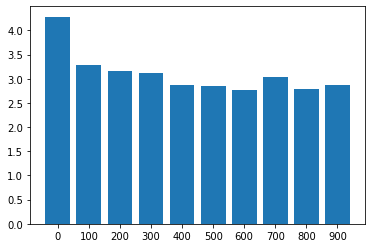

In [14]:
plt.bar(range(len(brushstroke_epoch_feature_losses)), list(brushstroke_epoch_feature_losses.values()), align='center')
plt.xticks(range(len(brushstroke_epoch_feature_losses)), list(brushstroke_epoch_feature_losses.keys()))

plt.show

<function matplotlib.pyplot.show(*args, **kw)>

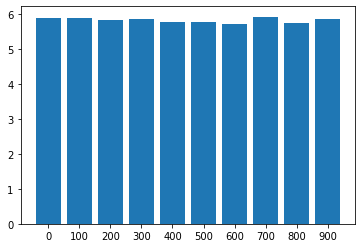

In [15]:
plt.bar(range(len(DCGAN_epoch_feature_losses)), list(DCGAN_epoch_feature_losses.values()), align='center')
plt.xticks(range(len(DCGAN_epoch_feature_losses)), list(DCGAN_epoch_feature_losses.keys()))

plt.show

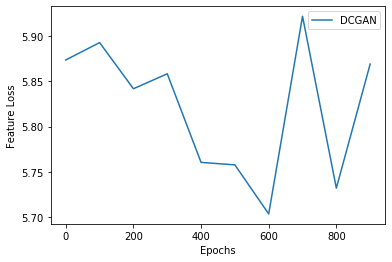

In [16]:
plt.plot(list(DCGAN_epoch_feature_losses.keys()), list(DCGAN_epoch_feature_losses.values()), label='DCGAN')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Feature Loss')

# optional save fig
# plt.savefig('DCGAN Feature Loss.png')

<function matplotlib.pyplot.show(*args, **kw)>

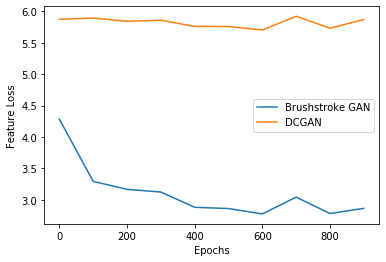

In [17]:
plt.plot(list(brushstroke_epoch_feature_losses.keys()), list(brushstroke_epoch_feature_losses.values()), label='Brushstroke GAN')
plt.plot(list(DCGAN_epoch_feature_losses.keys()), list(DCGAN_epoch_feature_losses.values()), label='DCGAN')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Feature Loss')

# optional save fig
# plt.savefig('Brushstroke v DCGAN Feature Loss.png')


plt.show

{0: tensor(4.2813, grad_fn=<AddBackward0>), 100: tensor(3.2908, grad_fn=<AddBackward0>), 200: tensor(3.1648, grad_fn=<AddBackward0>), 300: tensor(3.1217, grad_fn=<AddBackward0>), 400: tensor(2.8787, grad_fn=<AddBackward0>), 500: tensor(2.8584, grad_fn=<AddBackward0>), 600: tensor(2.7730, grad_fn=<AddBackward0>), 700: tensor(3.0407, grad_fn=<AddBackward0>), 800: tensor(2.7788, grad_fn=<AddBackward0>), 900: tensor(2.8619, grad_fn=<AddBackward0>)}
